<a href="https://colab.research.google.com/github/devshah21/nuclei_segmentation/blob/main/nuclei_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
with ZipFile('gdrive/MyDrive/google_colab_files/stage1_train.zip', 'r') as zipObj:
  zipObj.extractall('gdrive/MyDrive/google_colab_files/traindata')

In [7]:
with ZipFile('gdrive/MyDrive/google_colab_files/stage1_test.zip', 'r') as zipObj:
  zipObj.extractall('gdrive/MyDrive/google_colab_files/testdata')

In [38]:
traindatapath = '/content/drive/MyDrive/google_colab_files/traindata/'
testdatapath = '/content/gdrive/MyDrive/google_colab_files/testdata/'

In [26]:
import os

In [28]:
trainids = next(os.walk(traindatapath))[1]

In [31]:
try:
    testids = next(os.walk(testdatapath))[1]
except StopIteration:
    testids = []

In [32]:
imgwidth = 128
imgheight = 128
channels = 3

In [73]:
inputs = tf.keras.layers.Input((imgwidth, imgheight, channels))

In [67]:
import numpy as np

xtrain = np.zeros((len(trainids), imgheight, imgwidth, channels), dtype=np.uint8)
ytrain = np.zeros((len(trainids), imgheight, imgwidth, 1), dtype=np.bool_)

In [54]:
import random
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf

In [69]:
for i, id in enumerate(trainids):
  paths = traindatapath + id #path to image
  image = imread(paths + '/images/' + id + '.png')[:,:,:channels]
  image = resize(image, (imgheight, imgwidth), mode = 'constant', preserve_range=True)
  xtrain[i] = image #add values to empty array 
  mask = np.zeros ((imgheight, imgwidth, 1), dtype = np.bool_)
  for maskpath in next(os.walk(paths + '/masks/'))[2]: #loop through each mask
    masks = imread(paths + '/masks/' + maskpath)
    masks =  np.expand_dims(resize(masks, (imgheight, imgwidth), mode='constant', preserve_range=True), axis = -1)
    
    mask = np.maximum(mask, masks)
  ytrain[i] = mask



In [70]:
xtest = np.zeros((len(testids), imgheight, imgwidth, channels), dtype = np.uint8)
testsizes = []
#resize test images now
for k, id in enumerate(testids):
  paths = testdatapath + id
  image = imread(paths + '/images/' + id + '.png')[:,:,:channels]
  testsizes.append([image.shape[0], image.shape[1]])
  image = imread(paths + '/images/' + id + '.png')[:,:,:channels]
  xtest[k] = image

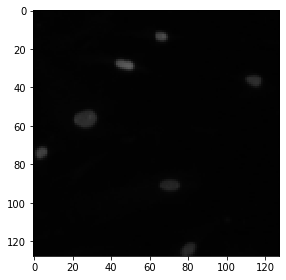

In [81]:
xvalue = random.randint(0, len(trainids))
imshow(xtrain[xvalue])
plt.show()

Define the UNET Architecture now








In [82]:
# Convert the integer values for the model into float values by dividing by 255. 
values = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Define the first conv layer, input the parameters from the U-Net diagram
conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(values)
# Prevent overfitting by using dropout function
conv1 = tf.keras.layers.Dropout(0.1)(conv1)
conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
down1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)

Repeat the following paramaters for the rest of the UNET model. The main focus here is to just define the structure/architecture for UNET.

In [83]:
conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(down1)
conv2 = tf.keras.layers.Dropout(0.1)(conv2)
conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
down2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)

In [84]:
conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(down2)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
down3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)

In [85]:
conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(down3)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
down4 = tf.keras.layers.MaxPooling2D(pool_size =(2,2))(conv4)

In [86]:
conv5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(down4)
conv5 = tf.keras.layers.Dropout(0.3)(conv5)
conv5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

Now we've finished the first half of the UNET architecture, the next step is to expand the model out after contracting it.

In [87]:
up6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(conv5)
up6 = tf.keras.layers.concatenate([up6, conv4]) #skip connections
conv6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(up6)
conv6 = tf.keras.layers.Dropout(0.2)(conv6)
conv6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

In [88]:
up7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(conv6)
up7 = tf.keras.layers.concatenate([up7, conv3]) #skip connections
conv7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(up7)
conv7 = tf.keras.layers.Dropout(0.2)(conv7)
conv7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

In [89]:
up8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(conv7)
up8 = tf.keras.layers.concatenate([up8, conv2])
conv8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(up8)
conv8 = tf.keras.layers.Dropout(0.1)(conv8)
conv8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8) 

In [90]:
up9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(conv8)
up9 = tf.keras.layers.concatenate([up9, conv1], axis=3)
conv9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(up9)
conv9 = tf.keras.layers.Dropout(0.1)(conv9)
conv9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9) 

In [91]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(conv9)

In [92]:
model = tf.keras.Model(inputs=[inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [93]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('nucleimodel.h5', verbose=1, save_best_only = True)

In [94]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir = 'logs')]
results = model.fit(xtrain, ytrain, validation_split = 0.1, batch_size = 16, epochs = 30, callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - 119s 3s/step - loss: 0.5028 - accuracy: 0.7886 - val_loss: 0.2754 - val_accuracy: 0.8170
Epoch 2/30
38/38 [==============================] - 117s 3s/step - loss: 0.2526 - accuracy: 0.8602 - val_loss: 0.1802 - val_accuracy: 0.9331
Epoch 3/30
38/38 [==============================] - 121s 3s/step - loss: 0.1554 - accuracy: 0.9424 - val_loss: 0.1274 - val_accuracy: 0.9479
Epoch 4/30
38/38 [==============================] - 115s 3s/step - loss: 0.1274 - accuracy: 0.9513 - val_loss: 0.1119 - val_accuracy: 0.9561
Epoch 5/30
38/38 [==============================] - 123s 3s/step - loss: 0.1146 - accuracy: 0.9562 - val_loss: 0.1074 - val_accuracy: 0.9587
Epoch 6/30
38/38 [==============================] - 116s 3s/step - loss: 0.1147 - accuracy: 0.9563 - val_loss: 0.1135 - val_accuracy: 0.9573
Epoch 7/30
38/38 [==============================] - 120s 3s/step - loss: 0.1101 - accuracy: 0.9585 - val_loss: 0.0959 - val_accuracy: 0.9620
Epoch 8/30
38